## Real GDP growth by state

In [1]:
# Settings and packages
%matplotlib inline

import sys
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon

plt.rc('font', family='Lato')

from mpl_toolkits.basemap import Basemap

# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

In [2]:
# College data from API and store in database
#api_results = bea_api_gdpstate(bea_key)

#bea_to_db(api_results)

In [3]:
# Retrieve data
data = gdpstate_df(retrieve_table('RGDP_SQN')['Data'])

states = list(set([i['STATE_NAME'] for i in m.states_info]))
regions = list(set([i['SUB_REGION'] for i in m.states_info]))
region_mapping = {region: list(set([i['STATE_NAME'] for i in m.states_info 
                                    if i['SUB_REGION'] == region])) 
                  for region in regions}

for region, state_list in region_mapping.items():
    data[region] = data[state_list].sum(axis=1)

data = data.drop([c for c in data.columns 
                  if c not in states 
                  and c not in regions
                  and c != 'United States'], axis=1)    
    
d = {}
oneyr = data.pct_change(4).iloc[-1] * 100
prevyr = data.iloc[-9:-4].pct_change(4).iloc[-1] * 100
tenyr = data.pct_change(41).iloc[-1] * 100
threeyr = data.pct_change(13).iloc[-1] * 100
last5 = ((1 + data.pct_change().iloc[-5:]) ** 4 - 1) * 100
d[0] = data.iloc[-5:]
d[1] = data.iloc[-9:-4]
d[2] = oneyr
d[3] = prevyr

cmap = plt.cm.Spectral
norm = Normalize(vmin=-8, vmax=8)

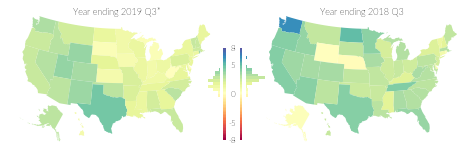

In [4]:
# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

# Draw map
for group in [0, 1]:
    plt.sca(axes[group])
    axes[group].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(d[group + 2][info['STATE_NAME']]))
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[group].add_patch(Polygon(shape, fc=fc))
    
    date = f'{d[group].index[-1].year} Q{d[group].index[-1].quarter}'
    if group == 0:
        date = date + '*'
    plt.text(0.32, 0.99, f'Year ending {date}', fontsize=9, 
             transform=axes[group].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [-8, -5, 0, 5, 8]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

for group, pt, pt2 in [(0, 0.71, 0.8), (1, 0.44, 0.39)]:
    for i in np.linspace(-8,8,65):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/64, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(d[group+2], np.linspace(-8,8,33)).apply(lambda x: x.left)
    res = d[group+2].groupby(bins).count()
    for i, v in res.items():
        if group == 0:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/32, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/gdp_map.pgf', bbox_inches='tight')

In [5]:
date = f'{d[0].index[-1].year} Q{d[0].index[-1].quarter}'

numbers = {0: 'no', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 
           6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}

cuts = [(5, 50), (2, 5), (0, 2), (-50, 0)]

d = {}
sd = oneyr.loc[states]
for minval, maxval in cuts:
    val = len(sd[(sd > minval) & (sd <= maxval)])
    if val < 10:
        txtval = numbers[val]
    else:
        txtval = str(val)
    if val == 1:
        d[maxval] = txtval + f' state ({oneyr.loc[states][oneyr > 5].index[0]})'
    else:
        d[maxval] = txtval + ' states'

In [6]:
text = [f'*For the year ending {date}, {d[50]} had real GDP growth of more than five percent, {d[5]} had real GDP growth between two and five percent, {d[2]} had less than two percent GDP growth, and {d[0]} had negative GDP growth. ']

f = text_dir.joinpath('gdp_state.txt')
with f.open('w') as wf:
    for t in text:
        print(t)
        wf.write(t + '\n')

*For the year ending 2019 Q3, no states had real GDP growth of more than five percent, 22 states had real GDP growth between two and five percent, 27 states had less than two percent GDP growth, and two states had negative GDP growth. 


In [7]:
# Print latest date to file
f = text_dir.joinpath('gdp_state_date.txt')
with f.open('w') as wf:
    wf.write(date)

In [8]:
date

'2019 Q3'

In [9]:
f = data_dir / 'gdp_state_table.tex'
os.remove(f)

newpage = '\end{tabular} } \\\\ \\newpage'

header = """\hspace{-2mm} \\noindent \\rowcolors{1}{}{black!5} 
            \setlength{\\tabcolsep}{3.8pt} \color{black!90}
            {\\renewcommand{\\arraystretch}{1.44}
             \\begin{tabular}{p{30mm} R{7mm} R{7mm} R{7mm} R{7mm} 
             R{7mm} p{0mm} R{9mm} R{9mm} R{10mm} }"""

contdrow = "\multicolumn{3}{l}{continued on next page . . .} & &  & & & & & \\\\"
contdrow2 = "\multicolumn{3}{l}{continued from previous page . . .}  & &  & & & & & \\\\"



tbl_dates = {}
for i in range(1, 6):
    dt = last5['Alabama'].index[-i]
    q = dt.quarter
    y = dt.year
    if i == 1:
        tbl_dates[i] = f'{y} Q{q}'
    else:
        tbl_dates[i] = f"'{str(y)[-2:]} Q{q}"

i = 0 
        
daterow = (f' & {tbl_dates[1]} & {tbl_dates[2]} & {tbl_dates[3]} & {tbl_dates[4]}'
           f' & {tbl_dates[5]} & & 1-year* & 3-year & 10-year \\\\')
with open(f, 'a') as table:
    table.write(daterow + '\n')
    area = 'United States'
    rate = f"{oneyr[area]:.1f} & {threeyr[area]:.1f} & {tenyr[area]:.1f} \\\\"
    last = ' & '.join(last5[area].round(1).astype(str).values)
    table.write('\\textbf{' + area + '}  & ' + last + ' &  & ' + rate + '\n')
    i = i + 1
    
    reg_sorted = list(tenyr.loc[regions].sort_values(ascending=False).index)

    for region in reg_sorted:
        rate = f"{oneyr[region]:.1f} & {threeyr[region]:.1f} & {tenyr[region]:.1f} \\\\"
        last = ' & '.join(last5[region].round(1).astype(str).values)
        table.write('\hspace{1mm} \\textbf{' + region + '}  & ' + last + ' &  & ' + rate + '\n')
        i = i + 1
        region_mapping[region]
        for state in list(tenyr[region_mapping[region]].sort_values(ascending=False).index):
            rate = f"{oneyr[state]:.1f} & {threeyr[state]:.1f} & {tenyr[state]:.1f} \\\\"
            last = ' & '.join(last5[state].round(1).astype(str).values)
            table.write('\hspace{3mm}  ' + state + '  & ' + last + ' &  & ' + rate + '\n')
            i = i + 1
            if i == 20:
                table.write(contdrow + '\n')
                table.write(newpage + '\n')
                table.write('' + '\n')
                table.write(header + '\n')
                table.write(daterow + '\n')
                table.write(contdrow2 + '\n')